## TRAPPIST-1 K2 Quicklook

### Lightcurves made with k2p2 (raw photometry: https://arxiv.org/abs/1504.05199) and k2sc (detrending: https://github.com/OxES/k2sc)

### Contributors: Rasmus Handberg, Tim White, Benjamin Pope, Suzanne Aigrain

This is an *extremely* preliminary stab at a K2 lightcurve of TRAPPIST-1 - we haven't manually gone through and checked everything is right - but we are motivated to release what we have now by rumours on social media of a TRAPPIST-1h discovery already. We will hopefully improve on this in future if there is interest and welcome feedback on this lightcurve.

GP fit to long cadence data via usual k2sc pipeline, taking centroids instead of WCS information though. GP fit to short cadence data using unpublished Aigrain+ method which divides it up into chunks, processes each one separately, and stitches together. All mistakes Ben Pope's entirely.

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
from scipy.ndimage import gaussian_filter1d

% matplotlib inline

import matplotlib as mpl

print mpl.style.available
mpl.style.use('seaborn-colorblind')

#To make sure we have always the same matplotlib settings
#(the ones in comments are the ipython notebook settings)

mpl.rcParams['figure.figsize']=(8.0,6.0)    #(6.0,4.0)
mpl.rcParams['font.size']=18               #10 
mpl.rcParams['savefig.dpi']= 200             #72 
mpl.rcParams['axes.labelsize'] = 16
mpl.rcParams['axes.labelsize'] = 16
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12

[u'seaborn-darkgrid', u'seaborn-notebook', u'classic', u'seaborn-ticks', u'grayscale', u'bmh', u'seaborn-talk', u'dark_background', u'ggplot', u'fivethirtyeight', u'seaborn-colorblind', u'seaborn-deep', u'seaborn-whitegrid', u'seaborn-bright', u'seaborn-poster', u'seaborn-muted', u'seaborn-paper', u'seaborn-white', u'seaborn-pastel', u'seaborn-dark', u'seaborn-dark-palette']


In [3]:
lc = Table.read('trappist_1_k2sc_lc.fits.gz')
sc = Table.read('trappist_1_k2sc_sc.fits.gz')

In [4]:
print lc.keys()

['time', 'cadence', 'quality', 'x', 'y', 'flux', 'error', 'mflags', 'trtime', 'trposi']


time means time - cadence is cadence number - that should be easy. The rest:

quality flags are a bit ad hoc, anything != 0 you should throw away for the moment. We haven't gone through these properly.

x, y are centroids. Treat with caution - not as good as proper WCS fits to the whole star field.

flux is raw aperture photometry, normalized.

trtime and trposi are GP trends for time and position respectively.

In [7]:
corr_flux_lc = lc['flux'] - lc['trposi'] + np.nanmedian(lc['trposi']) # subtract position trend
corr_flux_sc = sc['flux'] - sc['trposi'] + np.nanmedian(sc['trposi']) 


whitened_lc = corr_flux_lc - lc['trtime'] # prewhiten for transit searches
whitened_sc = corr_flux_sc - sc['trtime']

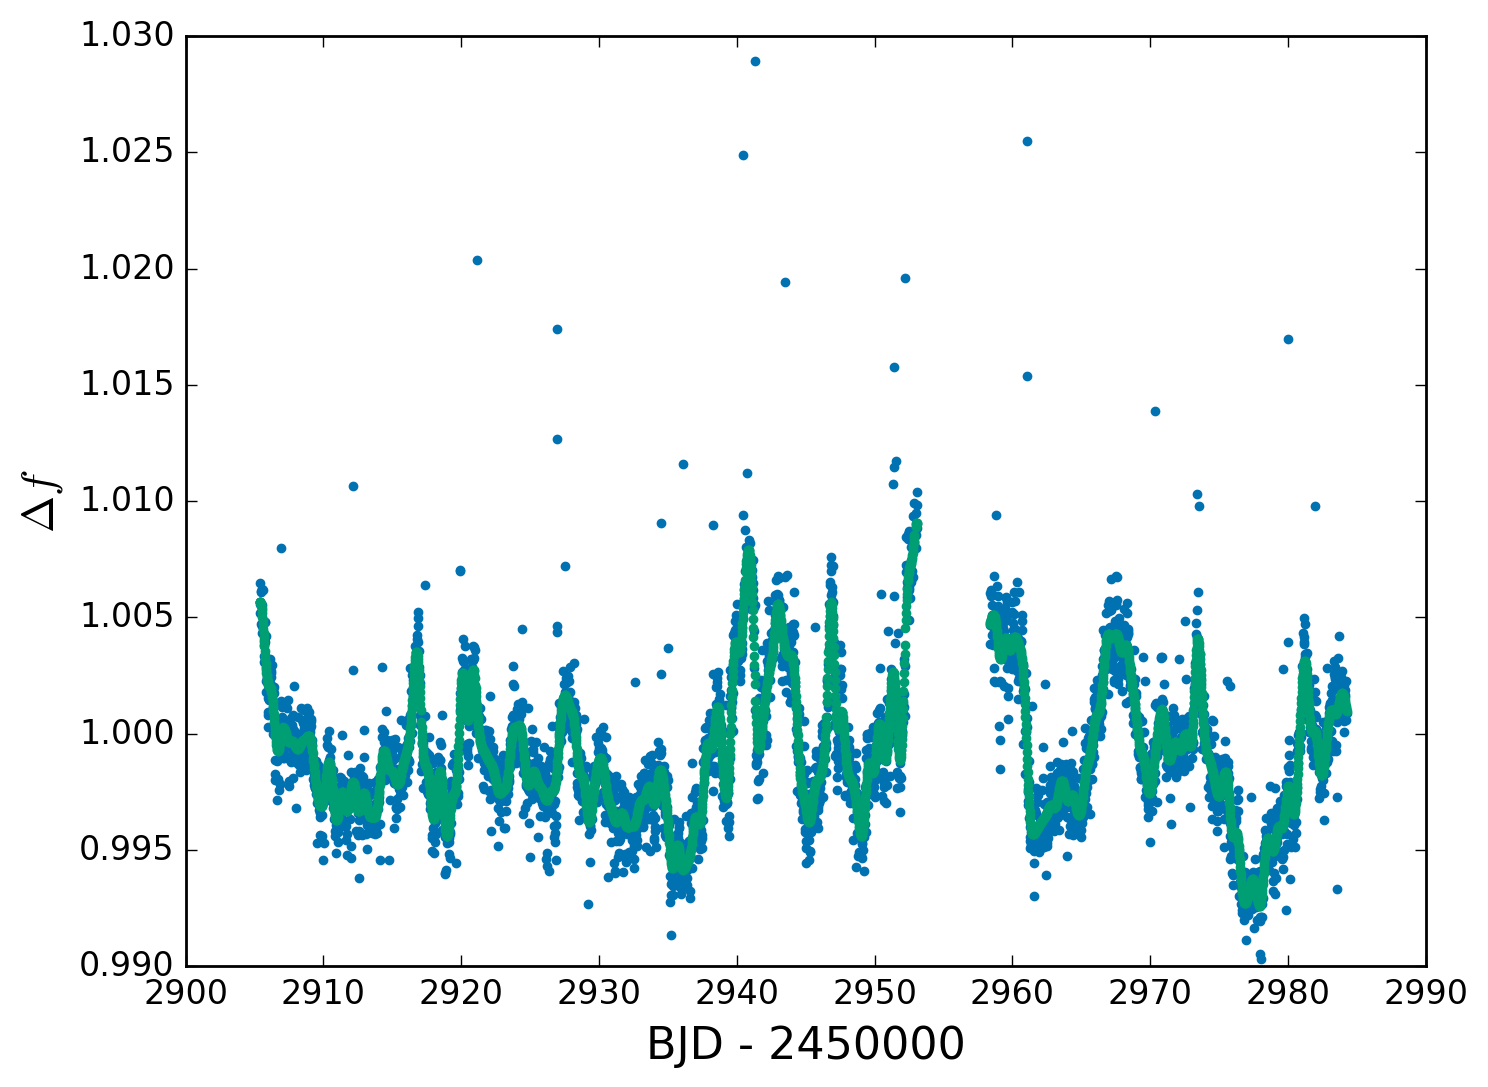

In [57]:
# look at long cadence data
good = lc['quality']==0
plt.plot(lc['time'][good],corr_flux_lc[good],'.')
plt.plot(lc['time'][good],lc['trtime'][good],'.')

plt.xlabel('BJD - 2450000')
plt.ylabel(r'$\Delta f$')


(2908, 2910)

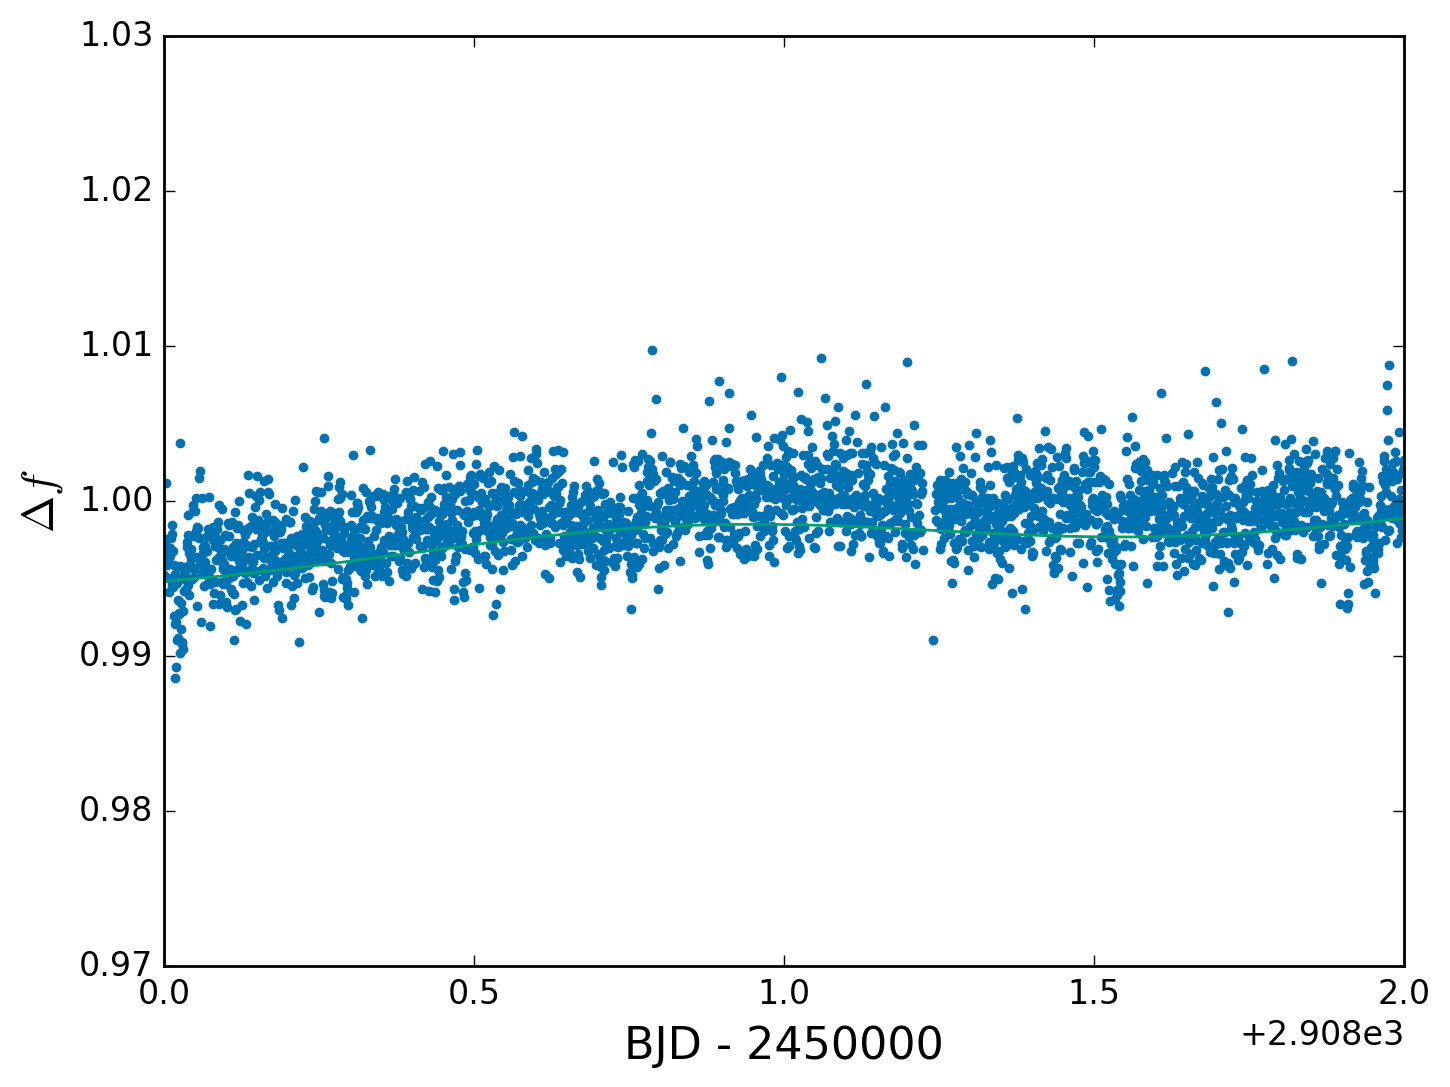

In [69]:
# look at short cadence data

# GP fit is a bit poor as you can see! Oh well

new_corr = corr_flux_sc[m][n]
plt.plot(new_time,new_corr,'.')
plt.plot(new_time,sc['trtime'][m][n])
plt.xlabel('BJD - 2450000')
plt.ylabel(r'$\Delta f$')
plt.xlim(2908,2910)

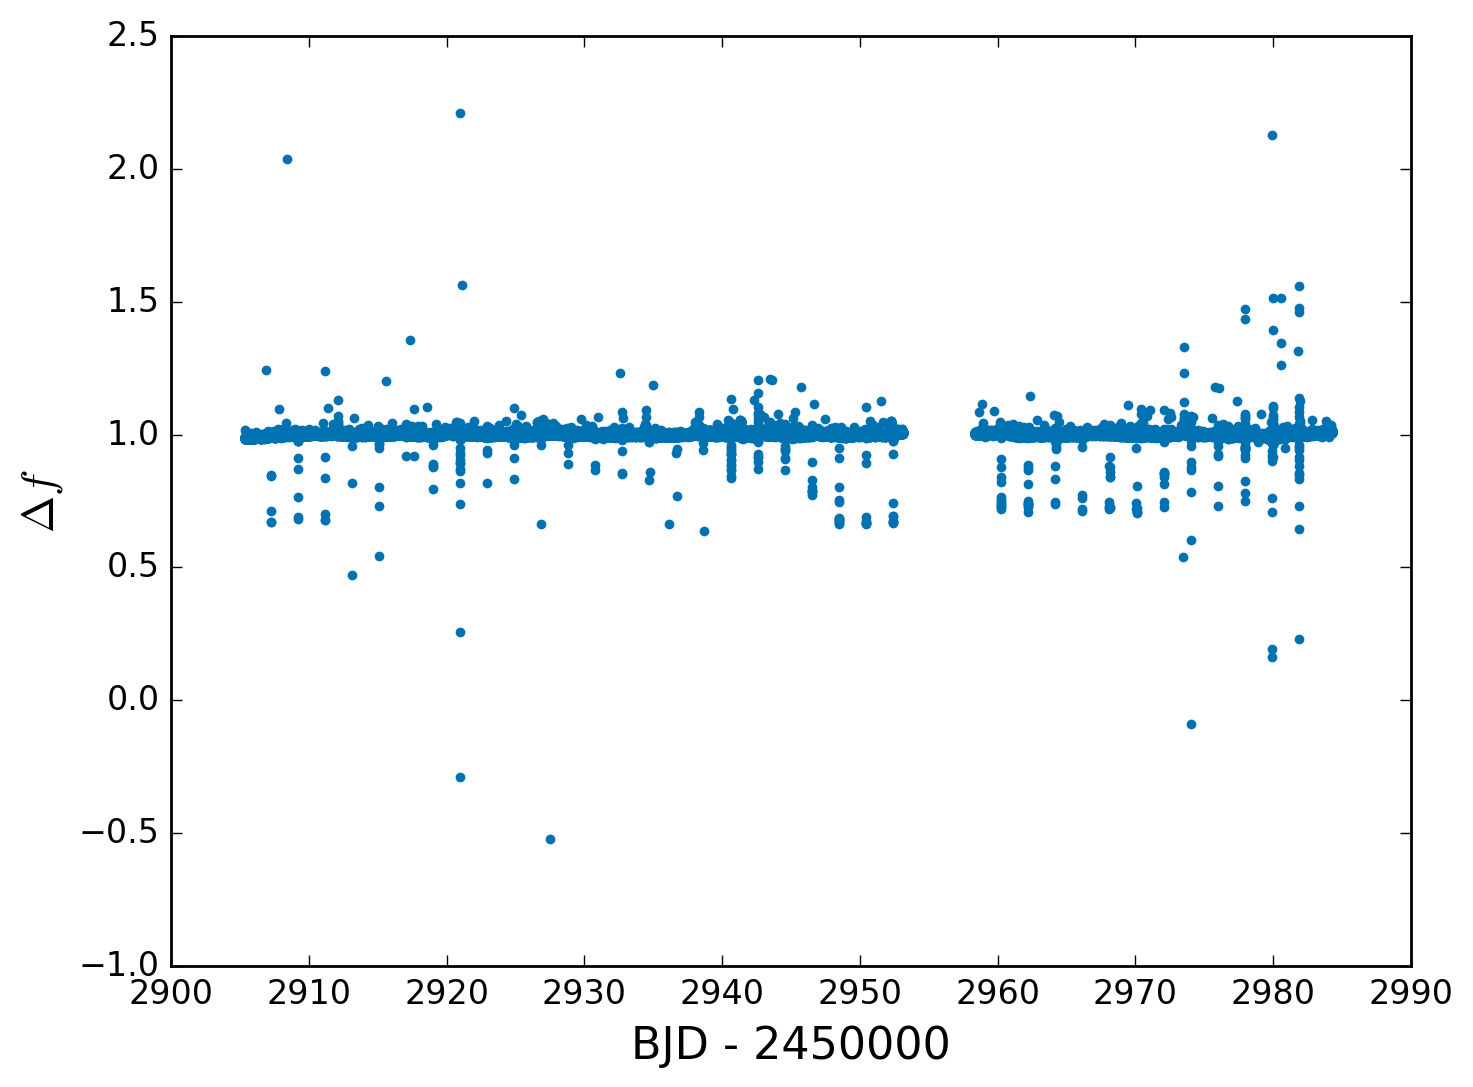

In [59]:
# check out prewhitened short cadence - looks pretty rubbish with artefacts everywhere
plt.plot(sc['time'],corr_flux_sc,'.')
plt.xlabel('BJD - 2450000')
plt.ylabel(r'$\Delta f$')


The short cadence looks a bit rubbish, doesn't it? Let's filter this a bit more aggressively.

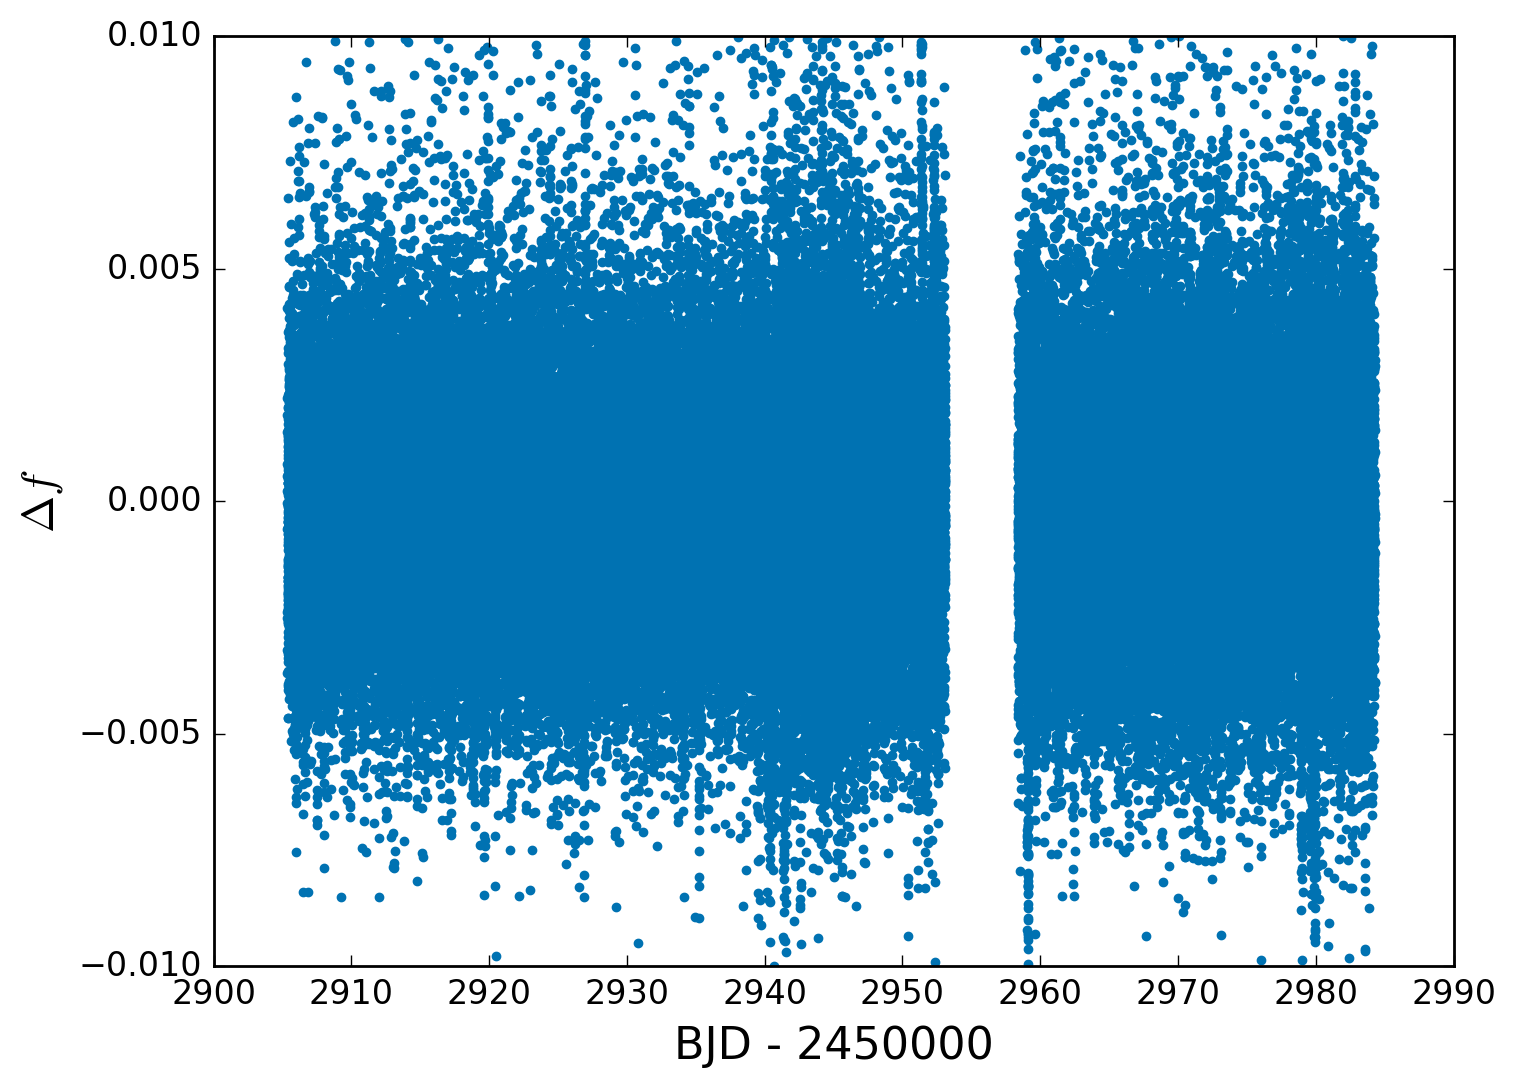

In [56]:
# plt.plot(t1,cfflux,'.')
m = (sc['quality']==0)*(np.abs(sc['flux_corr']-sc['trtime'])<0.03)
new_time, new_flux = sc['time'][m], sc['flux_corr'][m]-sc['trtime'][m]

new_smooth = gaussian_filter1d(new_flux,500) # GP didn't smooth enough
new_flux = new_flux - new_smooth
n = (new_flux<0.01) * (new_flux>-0.01) # arbitrary cuts for convenience 
new_time, new_flux = new_time[n], new_flux[n]

plt.plot(new_time,new_flux,'.')
plt.xlabel('BJD - 2450000')
plt.ylabel(r'$\Delta f$')


In [31]:
periods = [1.5109632323652062,2.421910525444853,4.0505318429961719,6.0995544784843609, 9.2079723228010764,12.354462172214392]
t0s = [7322.4891403600031, 7282.786894540307,7670.1268511628368,7660.370193264971,7671.3602433651558,7665.3554990344319] # from barclay
delta = 2454833-2450000 # time offset between barclay's system and this one


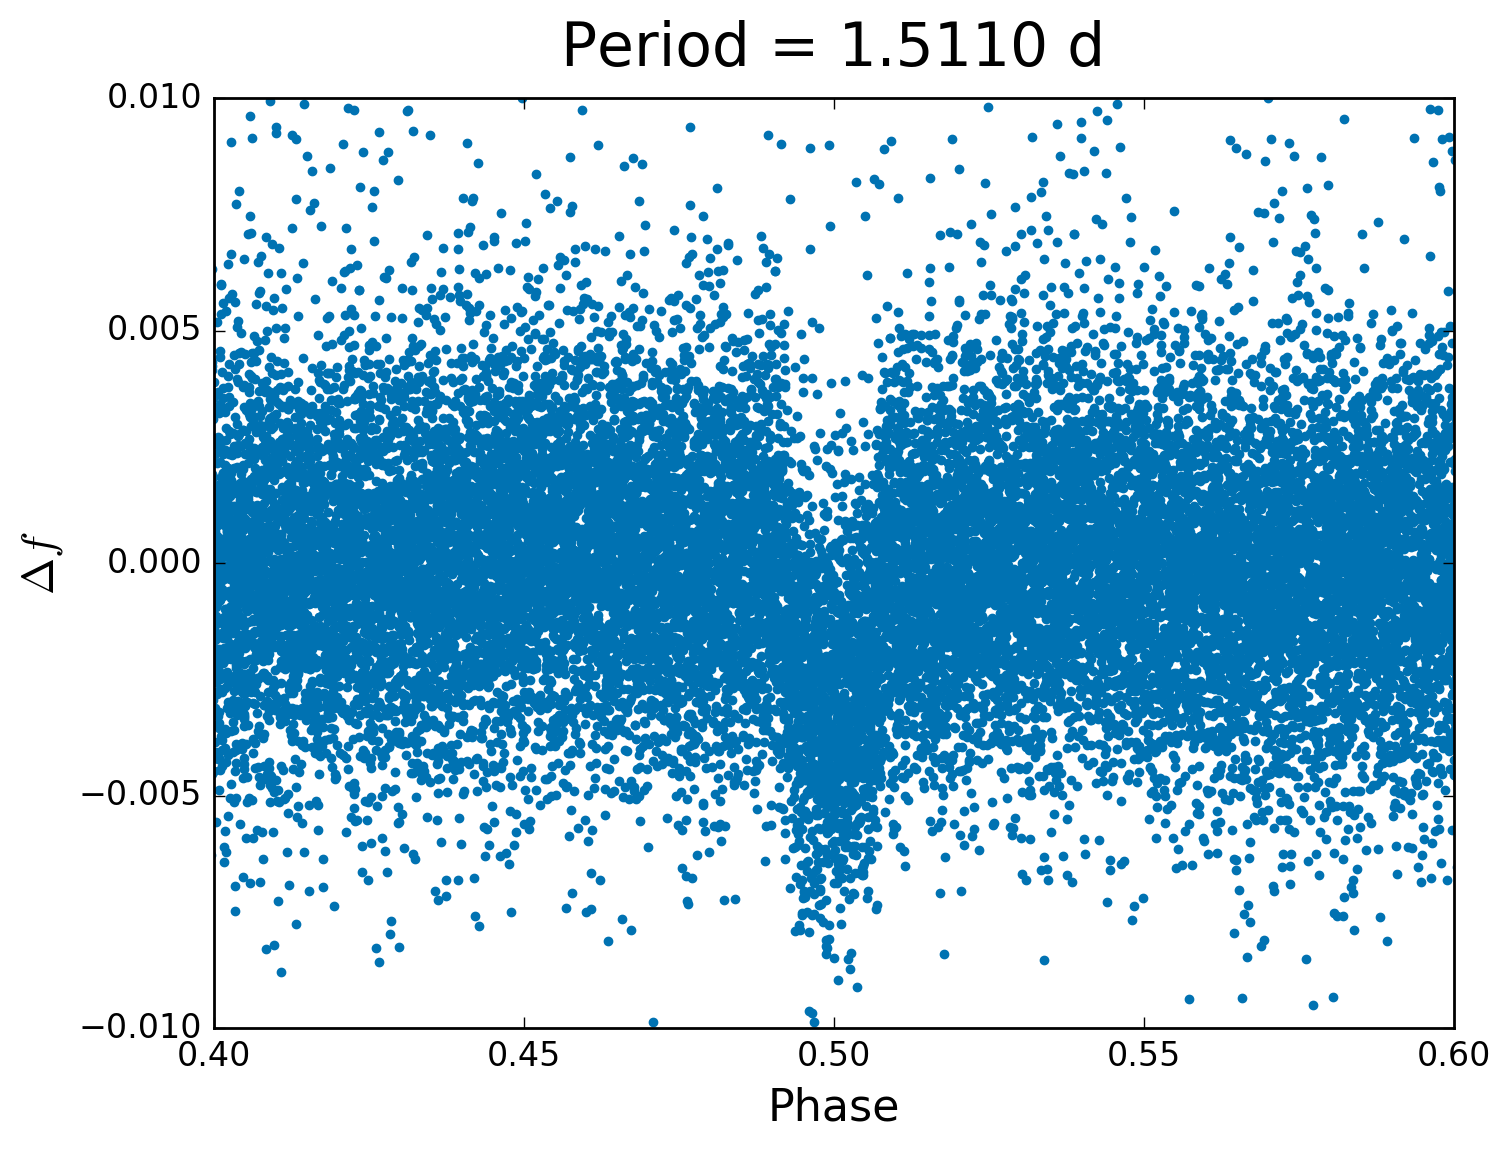

In [55]:
j = 0
folded = ((new_time-t0s[j]+delta + 0.5*periods[j]) % periods[j])/periods[j]

plt.plot(folded,new_flux,'.')
plt.xlim(0.4,0.6)
plt.xlabel('Phase')
plt.ylabel(r'$\Delta f$')
plt.title('Period = %.4f d' % periods[j],y=1.02)

In [60]:
from astropy.io import fits

In [68]:
fits.getdata('../trappist_1_k2sc_sc.fits.gz')

IOError: Empty or corrupt FITS file